<a href="https://colab.research.google.com/github/nithecs-biomath/mini-schools/blob/main/cubes_prac_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecological Modelling

**Techniques and Tools for Ecological Modelling**

In this lecture, participants will explore advanced analytical techniques and tools for ecological modelling using data cubes, with a focus on understanding climate-related impacts and adaptation strategies (SDG 13: Climate Action).

Let's walk through an example of how to use species occurrence data (e.g., from the Global Biodiversity Information Facility, GBIF) combined with climate data in Google Earth Engine (GEE) to understand climate-related impacts on species distributions. We'll also use Google Colab as our computational environment. This example will focus on visualizing the relationship between species occurrences and climate variables, and then assessing potential changes over time.

----

## System setup

##### Mount Google Drive

> In `Google Colab`, using `drive.mount` allows you to access files from your `Google Drive` directly within your Colab notebook. This is especially useful when working with larger datasets or pre-existing files stored in your Drive, such as data cubes, that need to be accessed and manipulated for ecological or biodiversity modeling. By mounting your Google Drive, you can load, save, and manage these resources without needing to upload them manually each time, streamlining the workflow for complex data analyses.

Follow the prompts to connect your Google Account account.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Import missing or update packages

> IIt may be necessary to install specific packages using `!pip` because not all Python libraries come pre-installed in the Colab environment. By using `!pip`, we can install any additional libraries required for our analysis that may not be included by default. This ensures that we have access to the latest tools, specialized libraries, and functionality needed for tasks such as ecological or biodiversity modeling, data cube manipulation, or visualization. This approach provides flexibility and ensures that the necessary dependencies are available to run the follow along in this session.

In [73]:
# Import missing or update packages
# !pip install rasterio
# !pip install localtileserver
# !pip install mapclassify
# !pip install -U geemap
# !pip install geemap==0.15.0 --quiet
# !pip install pygbif
# !pip install cartopy

##### Import, authenticate and activate Google Earth Engine (GEE)

> In order to use Google Earth Engine (GEE) within a Colab notebook, we first need to import the library, authenticate our account with `ee.Authenticate` and then initialize the Earth Engine API using `ee.Initialize`. The authentication step ensures that we have the proper permissions to access GEE's cloud-based platform and datasets. Following authentication, `ee.Initialize` establishes a connection between the notebook and GEE, allowing us to utilize its vast datasets, algorithms, and processing power for tasks such as ecological or biodiversity modeling. These steps are essential to fully leverage GEE's capabilities in a secure and authorized environment.

Follow the prompts to connect your GEE account.

In [3]:
# Import, authenticate and activate Earth Engine (EE)
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-biodatacube')

##### Import the rest of the packages

> In Python, `import` and `from ... import ... as` are used to bring external libraries or specific functions into your code. The `import` statement allows you to load entire libraries, such as `NumPy` or `pandas`, making all their functions available. The `from ... import` syntax is used when you only need specific functions or classes from a library, reducing the code overhead. Adding `as` allows you to give the imported module or function an alias, making it shorter and easier to reference in your code. This is especially helpful in data analysis, where concise, readable code improves workflow efficiency. For example, `import numpy as np` lets you use `np` instead of numpy throughout your code.

In [6]:
# Import necessary libraries
import os, requests, math, random, time, zipfile
from io import BytesIO
from math import floor, ceil

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches

from pygbif import occurrences as occ

# import mapclassify
# import localtileserver
# import rasterio
# from rasterio.transform import from_origin
# from rasterio.features import shapes, rasterize

import folium
import geemap
import geemap.colormaps as cm

# import seaborn as sns
# from shapely.geometry import Point, box, Polygon

# from scipy.stats import entropy
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# from ipyleaflet import TileLayer

import cartopy.crs as ccrs
import cartopy.feature as cfeature

##### Some packages need to be installed each time when using Colab

> In `Colab`, the environment is temporary and resets each time the session is restarted. This means that any packages not included by default must be reinstalled every time you reload the notebook. For example, when trying to import a package like `rasterio` that isn't pre-installed, you'll encounter a `ModuleNotFoundError`. By using a conditional block, such as `try/except`, you can attempt to import the package first, and if it's missing, install it automatically using `!pip install`. This ensures that the necessary package is available in the session without manual reinstallation every time the notebook is reloaded.

In [5]:
try:
    import rasterio
except ModuleNotFoundError:
    !pip install rasterio
    import rasterio

# try:
#     import localtileserver
# except ModuleNotFoundError:
#     !pip install localtileserver
#     import localtileserver

# try:
#     import mapclassify
# except ModuleNotFoundError:
#     !pip install mapclassify
#     import mapclassify

try:
    import pygbif
except ModuleNotFoundError:
    !pip install pygbif
    import pygbif

try:
    import cartopy
except ModuleNotFoundError:
    !pip install cartopy
    import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 70.4 MB/s eta 0:00:00


----


## Access data

> To work with data in a `Jupyter notebook`, you first need to load it into your working environment. In this example, `pd.read_csv` is used to read a `CSV (Comma-Separated Values)` file into a `pandas` *DataFrame*, which is a structured data format ideal for analysis in `Python`. The file path `/content/drive/My Drive/nithecs/data/Cube_ZA_mainland.csv` indicates that the data is stored in your *Google Drive*, which has been mounted into the Colab environment. Once loaded into a variable like `za_data`, you can manipulate, analyse, and visualise the dataset directly in your notebook, enabling efficient data processing for your project.

### Species occurrence records

Even if you don't currently have access to occurrence data for the species of interest, you can obtain observational data about specific species through the GBIF API. The [GBIF API](https://techdocs.gbif.org/en/openapi/) is an interface that allows access to the species distribution data provided by GBIF, enabling users to search, filter, and download data, as well as acquire various information related to species.

In the code below, the `species_name` variable is assigned the scientific name of the species (e.g., *Lepidoptera* for all butterfly species), and the `country_code` variable is assigned the country code (e.g., ZA for South Africa). The `base_url` variable stores the address of the GBIF API. `params` is a dictionary containing parameters to be used in the API request:

* `scientificName`: Sets the scientific name of the species to be searched.
* `country`: Limits the search to a specific country.
* `hasCoordinate`: Ensures only data with coordinates (true) are searched.
* `basisOfRecord`: Chooses only records of human observation (`HUMAN_OBSERVATION`).
* `limit`: Sets the maximum number of results returned to 10000.

#### Local, customised or other `GitHub` data

> In addition to accessing data from your local files or *Google Drive*, you can directly load datasets from online repositories like `GitHub` into your *Jupyter notebook*. For example, using `pd.read_csv('https://raw.githubusercontent.com/...')` allows you to read data from a `GitHub` repository's raw file link. In this case, the dataset is being read from the `URL` using the `pandas` function `read_csv`, with the file located in a `GitHub` repository. The `sep='\t'` argument specifies that the file uses tab delimiters. This approach is efficient for sharing and accessing open-source data directly, without needing to download or manually upload files.

In [7]:
# za_data = pd.read_csv('/content/drive/My Drive/nithecs/data/Cube_ZA_mainland.csv')
za_data = pd.read_csv('https://raw.githubusercontent.com/nithecs-biomath/mini-schools/refs/heads/main/data/sample_data_SA.csv', sep='\t')

# Split yearmonth into separate year and month columns
za_data[['year', 'month']] = za_data['yearmonth'].str.split('-', expand=True)
za_data.head(4)

,yearmonth,qdgccode,familykey,family,specieskey,species,occurrences,familycount,year,month
0,2024-08,E034N27BB,5142.0,Thalassianthidae,2257659.0,Heterodactyla hemprichii,1,7.0,2024,08
1,2024-08,E034N27BB,7410.0,Cepheidae,2264568.0,Cephea cephea,1,3.0,2024,08
2,2024-08,E034N27BB,8540.0,Lethrinidae,2374885.0,Lethrinus nebulosus,1,74.0,2024,08
3,2024-08,E034N27BB,8542.0,Lutjanidae,2384758.0,Lutjanus bohar,1,71.0,2024,08


#### GBIF data

> The [**Global Biodiversity Information Facility (GBIF)**](gbif.org) is an international open-access platform that provides access to biodiversity data from multiple sources worldwide. It enables researchers, ecologists, and conservationists to access millions of biodiversity records, including species occurrences, environmental data, and taxonomic information. There are several ways to import GBIF data into a `Jupyter notebook`. One method is through direct downloads from the GBIF website, which provides data files in CSV format that can be read using `pd.read_csv`. Alternatively, Python libraries like `pygbif` offer an API to query and retrieve specific datasets programmatically. You can also access GBIF data through integrated services like R’s `rgbif` package or within geospatial platforms such as Google Earth Engine, allowing seamless access to extensive biodiversity records for analysis.

##### GBIF API through `pygbif`

> `pygbif` is a Python package that provides easy access to the GBIF API, allowing users to search, retrieve, and manipulate biodiversity data directly from GBIF's vast database. It simplifies querying species occurrence records, taxonomic data, and metadata about biodiversity.

The code snippet retrieves species occurrence data from GBIF using the `pygbif` package. The function `occ.search(taxonKey=212, limit=100)` queries the GBIF API for up to 100 occurrence records of a specific taxon, identified by its taxonKey (in this case, 212). The returned data is stored in `df_api`, which is initially a dictionary. Since the actual occurrence data is likely stored within the results key of this dictionary, the code converts the relevant portion into a pandas DataFrame using `pd.DataFrame(df_api['results'])`. This structure allows for easier data manipulation and analysis. Finally, `df_api.head(4)` displays the first four rows of the DataFrame, giving an overview of the retrieved occurrence data.

In [8]:
# Example from Maarten with all "birds" indicated by taxonKey=212
df_api = occ.search(taxonKey=212, limit=100)

# Convert the dictionary to a pandas DataFrame
df_api = pd.DataFrame(df_api['results']) # The actual data is likely within the 'results' key of the dictionary.

df_api.head(4)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,higherGeography,sampleSizeUnit,sampleSizeValue,habitat,verbatimEventDate,samplingEffort,behavior,infraspecificEpithet,dataGeneralizations,http://unknown.org/subspecies
0,4590289036,75085267-1991-4313-9075-6a12e821a51a,1928bdf0-f5d2-11dc-8c12-b8a03c50a862,e44d0fd7-0edf-477f-aa82-50a81836ab46,1928bdf0-f5d2-11dc-8c12-b8a03c50a862,FR,DWC_ARCHIVE,2024-03-20T17:33:36.256+00:00,2024-03-20T20:37:55.244+00:00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4878311304,963a6b96-4d22-4428-86e4-afee52cf4a8e,1a4e6112-b3af-402e-b29f-c2ade2167f72,f9c0c41b-6da4-4be4-b917-a6f7710f3dbc,1a4e6112-b3af-402e-b29f-c2ade2167f72,DK,DWC_ARCHIVE,2024-10-09T10:49:05.389+00:00,2024-10-09T11:03:42.265+00:00,235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4534187326,aa6c5ee6-d4d7-4a65-a04f-379cffbf4842,2754e9c0-0e43-4f65-968a-6f16b9c378ce,dcceb601-2fb0-49dc-9cd2-7c00056f2b2c,2754e9c0-0e43-4f65-968a-6f16b9c378ce,DE,BIOCASE,2024-10-10T18:06:43.802+00:00,2024-10-10T18:23:59.496+00:00,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4509156301,ba19fc1d-670c-426b-b99d-49f003792ac4,f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc,d973e647-8f5f-4e6e-a1c6-65930deb0590,f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc,RU,DWC_ARCHIVE,2024-10-09T17:45:35.425+00:00,2024-10-09T18:07:34.657+00:00,288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(df_api['scientificName'])

0                    Mareca strepera (Linnaeus, 1758)
1                       Sitta europaea Linnaeus, 1758
2                 Prunella modularis (Linnaeus, 1758)
3                  Pyrrhula pyrrhula (Linnaeus, 1758)
4                Aegithalos caudatus (Linnaeus, 1758)
                           ...                       
95                       Corvus corone Linnaeus, 1758
96                Erithacus rubecula (Linnaeus, 1758)
97                 Dendrocopos major (Linnaeus, 1758)
98    Poecile montanus (Conrad von Baldenstein, 1827)
99                         Parus major Linnaeus, 1758
Name: scientificName, Length: 100, dtype: object


###### >> Design function - **`fetch_gbif_data`**

Custom function that fetches occurrence data from the GBIF API and returns it as a pandas DataFrame with selected columns: familykey, family, specieskey, species, occurrences, latitude, longitude. This [example link](http://api.gbif.org/v1/occurrence/search?facet=speciesKey&country=US&year=1800,1900&basisOfRecord=HUMAN_OBSERVATION) demonstrates how the GBIF API can be queried to search for species occurrences using parameters like country (US), time period (year=1800,1900), and type of observation (basisOfRecord=HUMAN_OBSERVATION). This approach enables customized, programmatic access to GBIF data for biodiversity research, making it easier to integrate into notebooks or scripts.

> In some cases, custom functions like `fetch_gbif_data` can be used instead of built-in functions from libraries such as `pygbif` to allow greater flexibility and control over how data is retrieved and processed. This custom function allows you to define multiple parameters (e.g., occurrence_status, basis_of_record, continent, coordinate_uncertainty_in_meters, etc.), providing a tailored way to filter GBIF occurrence data. Built-in functions may have limited options or may require multiple steps to achieve the same result. A custom function consolidates all these features into a single, reusable block of code, making it easier to refine the query for your specific research needs, such as selecting species occurrences by geographic extent, filtering records by year or coordinate uncertainty, or applying additional custom filters. This approach also ensures the output format (e.g., a pandas DataFrame with specific columns) matches your workflow, streamlining further analysis.

In [14]:
def fetch_gbif_data(occurrence_status="present",
                    basis_of_record=None, #"HUMAN_OBSERVATION",
                    continent=None, # AFRICA
                    has_coordinate=True,
                    has_geospatial_issue=False,
                    coordinate_uncertainty_in_meters=(0, 1000),
                    kingdom=None,
                    taxon_key=None,  # Example: 1108 for a specific taxon
                    species_name=None,
                    country_code="ZA",
                    max_records=300,
                    start_year=2010,
                    end_year=2022,
                    province=None,
                    extent=None):
    """
    Fetches occurrence data from the GBIF API and returns it as a pandas DataFrame
    with selected columns: familykey, family, specieskey, species, occurrences, latitude, longitude.

    Parameters:
    occurrence_status (str): Status of the occurrence (e.g., "present", "absent").
    basis_of_record (str): Basis of the record (e.g., "HUMAN_OBSERVATION", "PRESERVED_SPECIMEN").
    continent (str): Continent to filter records (optional, e.g., "AFRICA").
    has_coordinate (bool): Whether to include only records with coordinates (default True).
    has_geospatial_issue (bool): Whether to include records with geospatial issues (default False).
    coordinate_uncertainty_in_meters (tuple): Min and max uncertainty in meters for coordinates (default (0, 1000)).
    kingdom (str): Kingdom name to filter records (optional, e.g., "Plantae").
    taxon_key (int): Taxon key for the species (optional).
    species_name (str): Scientific name of the species (optional).
    country_code (str): Country code (default "ZA" for South Africa).
    max_records (int): Maximum number of records to fetch (default 300).
    start_year (int): Start year for filtering records (default 2000).
    end_year (int): End year for filtering records (default 2024).
    province (str): GADM code for the province (optional).
    extent (tuple): Geographic extent as a tuple of (min_lat, min_lon, max_lat, max_lon) for bounding box filter (optional).

    Returns:
    pd.DataFrame: DataFrame containing the GBIF occurrence data with selected columns.
    """

    base_url = "https://api.gbif.org/v1/occurrence/search"
    limit = 300  # Maximum number of records per request (set by GBIF API)
    offset = 0   # Initial offset
    all_records = []  # List to store all records

    # Loop to fetch data in batches until max_records or until no more data is returned
    while offset < max_records:
        # Set up parameters for the API request
        params = {
            "occurrenceStatus": occurrence_status,        # Occurrence status
            "basisOfRecord": basis_of_record,             # Basis of the record
            "country": country_code,                      # Country code (e.g., South Africa)
            "hasCoordinate": str(has_coordinate).lower(), # Convert boolean to string
            "hasGeospatialIssue": str(has_geospatial_issue).lower(), # Convert boolean to string
            "coordinateUncertaintyInMeters": f"{coordinate_uncertainty_in_meters[0]},{coordinate_uncertainty_in_meters[1]}",  # Uncertainty range
            "limit": min(limit, max_records - offset),    # Adjust limit for remaining records
            "offset": offset,
            "year": f"{start_year},{end_year}",           # Filter records between start_year and end_year
        }

        # Add kingdom to params if provided
        if kingdom:
            params["kingdom"] = kingdom

        # Add taxonKey to params if provided
        if taxon_key:
            params["taxonKey"] = taxon_key

        # Add speciesName to params if provided
        if species_name:
            params["scientificName"] = species_name

        # Add province filter if provided
        if province:
            params["gadmGid"] = province  # GADM code for the administrative region

        # Add continent filter if provided
        if continent:
            params["continent"] = continent

        # Add geographic extent filter if provided
        if extent:
            min_lat, min_lon, max_lat, max_lon = extent
            # Create WKT polygon from extent
            wkt_polygon = f"POLYGON(({min_lon} {min_lat}, {min_lon} {max_lat}, {max_lon} {max_lat}, {max_lon} {min_lat}, {min_lon} {min_lat}))"
            params["geometry"] = wkt_polygon

        # Send the GET request to the GBIF API
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            results = data.get('results', [])

            # Break loop if no more results are found
            if not results:
                break

            # Add records to the list
            all_records.extend(results)

            # Increment offset for the next batch
            offset += limit
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
            break

    # Convert all collected records to a pandas DataFrame
    df = pd.json_normalize(all_records)

    # Keep only the desired columns
    desired_columns = ['year', 'month', 'familyKey', 'family', 'speciesKey', 'species', 'decimalLatitude', 'decimalLongitude']
    df = df[desired_columns]

    # # Rename columns for consistency
    # df.columns = ['year', 'month', 'familykey', 'family', 'specieskey', 'species', 'latitude', 'longitude']

    # Add new column 'occurrences' with value 1 for all records
    df['occurrences'] = 1

    # Return the DataFrame
    return df

###### >> Run function - **`fetch_gbif_data`**

> To run the `fetch_gbif_data` function and retrieve specific GBIF records, the process begins by setting up the parameters that define the scope of the data you want. In this example, we start a timer to track how long the data fetching process takes. The function is called with parameters specifying that we want to retrieve occurrence data for the *Anseriformes* (ducks, geese, and swans) in South Africa `(country_code="ZA")` between the years 2010 and 2022. Additional filters are applied to include only human observations `(basis_of_record="HUMAN_OBSERVATION")`, records with coordinates `(has_coordinate=True)`, and a maximum coordinate uncertainty of 1 km. The `taxon_key=1108` ensures that only *Anseriformes* records are retrieved, and the query is limited to `14,000` records. After fetching the data, the timer is stopped, and the elapsed time in minutes is calculated and displayed along with the total number of records retrieved. This procedure ensures efficient data retrieval with clear feedback on performance and output size.

In [15]:
# Start the timer
start_time = time.time()

# Fetch data for the Anseriformes from South Africa between the years 2010 and 2022
df_za = fetch_gbif_data(
    basis_of_record="HUMAN_OBSERVATION",
    continent="AFRICA",
    country_code="ZA",
    # province="ZAF.4_1",  # GADM code for Kwa-Zulu Natal
    # province="ZAF.9_1",  # GADM code for Western Cape
    # extent=(-34.06, 18.80, -33.10, 20.09),  # Bounding box for the desired extent
    has_coordinate=True,
    has_geospatial_issue=False,
    coordinate_uncertainty_in_meters=(0, 1000), # From 0m to 1km
    taxon_key=1108, # Anseriformes = ducks, geese, and swans
    max_records=14000, # Limit to 14 000 records. I know there are 12 914 in total
    start_year=2010,
    end_year=2022
)

# End the timer
end_time = time.time()
# Calculate elapsed time in seconds and convert to minutes
elapsed_minutes = (end_time - start_time) / 60

print(f"Time taken: {elapsed_minutes:.2f} minutes to import {len(df_za)} records")
print(f"Number of records/rows: {len(df_za)}")

Time taken: 3.74 minutes to import 12946 records
Number of records/rows: 12946


##### Zip URL

> A function like `load_from_url_zip` is useful when you need to download and process GBIF data that has already been packaged and compressed into a ZIP file, often through GBIF's interface. This approach is ideal when the dataset is too large or complex for an API query, or when you've used the GBIF website to apply specific filters and generate a bulk download. The function downloads the ZIP file from a provided URL, extracts its contents, and reads the relevant CSV data directly into a pandas DataFrame. Using this method allows you to handle pre-processed datasets efficiently, especially when working with large-scale biodiversity data, while automating the extraction and reading process. This is especially helpful if the dataset contains millions of records that would otherwise be difficult to fetch through the API.


###### >> Design function - **`load_from_url_zip`**

> The custom function, `load_from_url_zip`, is used when working with compressed biodiversity datasets (in ZIP format) that contain CSV or tab-separated values. It provides flexibility in error handling, content selection, and preprocessing that might not be available with built-in functions like those in `pygbif`. This is especially relevant when working in environments like Google Colab, where you may need to process large or irregular datasets in a specific way.

In [16]:
def load_from_url_zip(zip_url):
    response = requests.get(zip_url) # Make an HTTP request to the provided URL
    if response.status_code == 200: # Check if the response is successful (status code 200)
        zip_file = BytesIO(response.content) # Load the content of the ZIP file into memory
        with zipfile.ZipFile(zip_file, 'r') as z: # Open the ZIP file and extract its contents
            for filename in z.namelist(): # Loop through the filenames in the ZIP file
                if filename.endswith('.csv'):  # Find the file ending in '.csv'
                    with z.open(filename) as f: # Open the file and read it into a pandas DataFrame
                        # Read the CSV file, skipping bad lines to avoid format errors
                        df = pd.read_csv(f, sep='\t', on_bad_lines='skip')  # Use sep='\t' for tab-separated values
    else:
        print(f"Failed to download the file. Status code: {response.status_code}") # Print an error message if the download failed
        return None
    return df # Return the DataFrame with the data

###### >> Run function - **`load_from_url_zip`**

In [22]:
# URL path
url_zip = 'https://api.gbif.org/v1/occurrence/download/request/0038969-240906103802322.zip'

# Run function
df_url = load_from_url_zip(url_zip)

# Specify the columns to keep
df_url = df_url[['year', 'month', 'family', 'speciesKey', 'species', 'decimalLatitude', 'decimalLongitude']]
df_url.head(4)

,year,month,family,speciesKey,species,decimalLatitude,decimalLongitude
0,2013,10,Anatidae,5232465.0,Plectropterus gambensis,-25.162979,31.617205
1,2011,12,Anatidae,5232465.0,Plectropterus gambensis,-25.559278,30.059526
2,2010,12,Anatidae,5232465.0,Plectropterus gambensis,-34.062473,18.496857
3,2011,12,Anatidae,5232465.0,Plectropterus gambensis,-26.026592,27.855534


### Environmental data

> Including environmental data in ecological modeling is critical for understanding species richness and the factors driving biodiversity patterns. Environmental variables, such as climate, land cover, elevation, and human impact, can significantly influence species distribution and abundance. Incorporating these variables helps build more accurate models that explain species richness and predict future trends under changing environmental conditions. Numerous online sources provide access to environmental data, such as NASA Earthdata, Copernicus, and WorldClim. However, in this lesson, we will focus on using Google Earth Engine (GEE), a powerful cloud-based platform that allows access to extensive environmental datasets, such as satellite imagery and climate data. GEE's ability to process large-scale geospatial data makes it ideal for ecological modeling in Jupyter Notebooks or Colab, enabling efficient analysis of the relationships between environmental factors and species richness across large spatial scales. Through GEE, we can quickly integrate and analyze complex environmental data to better understand and conserve biodiversity.

#### Setup some parameters

> Setting up parameters or objects in a Jupyter notebook at the beginning is essential for ensuring clarity, consistency, and flexibility throughout your analysis. Defining variables such as the start_date, end_date, or a list of years and months enables easy modification of key aspects of your workflow, like the temporal range of data to process. This approach helps streamline repetitive tasks and makes your code more readable and adaptable, allowing you to focus on the analysis without needing to manually update each section. It also enhances reproducibility, as these parameters can be quickly adjusted to test different time frames or datasets without altering the core code logic.

In [23]:
# Define the date range for the collection
start_date = '2010-01-01'
end_date = '2022-12-31'

# Define the range of years and months you want to process
years = ee.List.sequence(2010, 2022)
months = ee.List.sequence(1, 12)

#### Administrative boundaries

[LSIB 2017: Large Scale International Boundary Polygons, Simplified](https://developers.google.com/earth-engine/datasets/catalog/USDOS_LSIB_SIMPLE_2017)

The dataset `ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")` is a simplified version of the U.S. Department of State’s Large Scale International Boundary (LSIB) dataset from 2017, hosted on Google Earth **Engine**. Here is a detailed description of the dataset. It's useful for tasks that involve international boundary context but do not require highly detailed or complex boundary geometries.

In [24]:
# Define the area of interest (South Africa, Lesotho, and Swaziland)
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
  .filter(ee.Filter.inList('country_na', ['South Africa', 'Lesotho', 'Swaziland']))

# Check how many countries are in the collection
print(f'Number of countries in the collection: {countries.size().getInfo()}')

# Create region or area of interest
# region_box = countries.geometry().bounds()
region = countries.geometry()


Number of countries in the collection: 3


#### Long-term rainfall

[**CHIRPS Pentad: Climate Hazards Center InfraRed Precipitation With Station Data (Version 2.0 Final)**](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_PENTAD):  
Climate Hazards Center InfraRed Precipitation with Station data (CHIRPS) is a 30+ year quasi-global rainfall dataset. CHIRPS incorporates 0.05° resolution satellite imagery with in-situ station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring.



In [25]:
# Climate Hazards Center InfraRed Precipitation with Station data (CHIRPS)
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')\
                            .filterDate(start_date, end_date)\
                            .filterBounds(region)
rain = chirps.select('precipitation')

# Check how many images are in the collection
print(f'Number of images in Rainfall collection: {rain.size().getInfo()}')


Number of images in Rainfall collection: 936


#### Long-term surface water trends

[**JRC Monthly Water Recurrence, v1.4**](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_MonthlyHistory):  
The JRC contains maps of the location and temporal distribution of surface water from 1984 to 2021 and provides statistics on the extent and change of those water surfaces.

In [26]:
# JRC Monthly Water History, v1.4
water = ee.ImageCollection('JRC/GSW1_4/MonthlyHistory')\
                            .filterDate(start_date, end_date)\
                            .filterBounds(region)\
                            .select('water')
                            # .filter(ee.Filter.date(start_date, end_date))\

# Create a mask for values equal to 2 i.e. water present
# water_occ = water.eq(2) #--> AttributeError: 'ImageCollection' object has no attribute 'eq'

# Use map() to apply the eq() function to each image in the collection
# Bitmask for water
# Bits 0-1: Water detection
# 0: No data
# 1: Not water
# 2: Water
water_occ = water.map(lambda image: image.eq(2))

# Check how many images are in the collection
print(f'Number of images in Surface Water collection: {water_occ.size().getInfo()}')

Number of images in Surface Water collection: 144


> geemap is a Python package that bridges Google Earth Engine (GEE) with interactive mapping capabilities in Jupyter notebooks or Colab. By using geemap, you can visualize spatial data interactively, making it easier to explore and analyze geospatial datasets directly within your notebook. This is particularly useful in ecological and biodiversity modeling, as it allows for dynamic visualization of environmental variables, land cover changes, or species distributions over time and space. With simple commands, geemap integrates GEE's powerful cloud computing resources with user-friendly maps and interactive plots, helping to better understand complex spatial patterns and relationships in your data.

 #### Plot environmental data using `geemap`

 Plot long-term mean rainfall and surface water occurrence for South Africa, Lesotho and Swaziland (eSwatini)

In [27]:
# Setup mapping environment
# Map = geemap.Map()
Map = geemap.Map(layout={'height':'600px', 'width':'800px'})
Map.centerObject(countries, 5)

In [28]:
# Define the visualization parameters directly in the Map.addLayer function
Map.addLayer(
    rain.mean().clip(region),
    {
        'min': 0,  # Minimum rainfall value for visualization
        'max': 20,  # Maximum rainfall value for visualization
        'palette': ['red','yellow','green','blue']  # Color palette to represent rainfall
    },
    'Monthly Mean Rainfall (mm)'
)

# Add a layer control to the map
Map.addLayerControl()

# Display the map
Map

Map(center=[-28.959427811491228, 25.363249892548207], controls=(WidgetControl(options=['position', 'transparen…

In [29]:
# Setup visualisation parameters

# Define visualization parameters for the rainfall raster
rainVis = {# 'bands': ['rain'],  # Band index starts from 0 in Earth Engine
    'palette': ['9e0142', 'd53e4f', 'f46d43', 'fdae61', 'fee08b', 'ffffbf', \
                    'e6f598', 'abe0a4', '66c2a5', '3288bd', '5e4fa2'],  # Define your color palette
    # 'palette': cm.palettes.YlGnBu,
    'min': 0,  # Minimum value for visualization
    'max': 6,  # Maximum value for visualization
    'opacity': 0.4
}

# Define visualization parameters for highlighting values 2
waterVis = {
    'palette': ['white', 'blue'],  # White for all others, blue for water occurrence value = 2
    'min': 0,     # Min count
    'max': 125,   # Max count
    'opacity': 0.4
}


In [30]:
# Add the water occurrence layer to the map
Map.addLayer(water_occ.sum().clip(region), waterVis, 'Total Water Occurrence')

# Add the mean rainfall layer to the map
Map.addLayer(rain.mean().clip(region),rainVis, 'Monthly Mean Rainfall (mm)')

# Add a layer control to the map
Map.addLayerControl()

# Display the map
Map

Map(bottom=5085.0, center=[-28.959427811491228, 25.363249892548207], controls=(WidgetControl(options=['positio…

----


## Process data

> Proper data preprocessing is critical for ensuring accurate and relevant analysis, as it directly influences the alignment of your data with your research question. A well-designed preprocessing pipeline helps clean, transform, and format the data to reflect key variables, improving data quality and streamlining future analyses. It also facilitates early error detection, allowing you to address inconsistencies, handle missing data, and reduce noise, ultimately leading to more robust and credible research outcomes.

### Species richness data cube

> Species richness, the number of different species present in a given area, is a fundamental metric of biodiversity and is highly relevant for ecological modeling. In this exercise, species richness serves as a key indicator of ecosystem health and biological diversity across spatial and temporal scales. By integrating species richness into the context of Data Cubes, we can explore how this metric varies over time and in response to environmental factors, such as climate change or habitat alterations. Data Cubes, which structure multidimensional data (e.g., species occurrences across space and time), allow for advanced analysis of species richness trends, facilitating better understanding of the drivers behind biodiversity patterns and enabling more effective conservation strategies.

First check the structure of the data we already imported


In [31]:
# Check data.frame format
df_url.head(4)

,year,month,family,speciesKey,species,decimalLatitude,decimalLongitude
0,2013,10,Anatidae,5232465.0,Plectropterus gambensis,-25.162979,31.617205
1,2011,12,Anatidae,5232465.0,Plectropterus gambensis,-25.559278,30.059526
2,2010,12,Anatidae,5232465.0,Plectropterus gambensis,-34.062473,18.496857
3,2011,12,Anatidae,5232465.0,Plectropterus gambensis,-26.026592,27.855534


> Rounding latitude and longitude coordinates into quarter-degree squares (QDS) is a common practice in ecological studies, particularly for visualizing species distributions. This approach simplifies spatial data by grouping observations into standardized grid cells, each representing 15x15 minutes or roughly 25 km². Many Atlas projects, such as the Southern African Bird Atlas Project (SABAP) and other biodiversity monitoring initiatives, use QDS to map species occurrences, providing a uniform framework for comparing distributions across different regions and time periods. By rounding coordinates to quarter degrees, we make species distribution maps easier to interpret and analyze, while also aligning our data with established methodologies in biodiversity research. This helps in visualizing and comparing species richness or presence-absence patterns over broad geographic scales.

In [32]:
# Round decimalLatitude and decimalLongitude to the nearest quarter degree
df_url['qds_lat'] = (df_url['decimalLatitude'] / 0.25).round() * 0.25
df_url['qds_lon'] = (df_url['decimalLongitude'] / 0.25).round() * 0.25

# Group by year, species, rounded latitude, and rounded longitude and count the occurrences
qds_sum = df_url.groupby(['year', 'species', 'qds_lat', 'qds_lon'])['species'].count().reset_index(name='count')

# Display the summary table
qds_sum.head(4)

,year,species,qds_lat,qds_lon,count
0,2010,Alopochen aegyptiaca,-34.25,18.50,1
1,2010,Alopochen aegyptiaca,-34.25,19.00,1
2,2010,Alopochen aegyptiaca,-34.00,18.50,15
3,2010,Alopochen aegyptiaca,-34.00,18.75,2


> The process of calculating species richness by counting the number of unique species names grouped by year, quarter-degree squares (QDS), latitude (qds_lat), and longitude (qds_lon) provides a clear picture of biodiversity patterns across space and time. By using the groupby method, we aggregate the dataset based on these geographic and temporal dimensions and then count the number of unique species in each group using `.nunique()`. This gives us the species richness for each QDS and year combination. After grouping, missing values are filled with zero to account for instances where no species were recorded in certain cells or years. The resulting table presents species richness over time and space, which is essential for understanding biodiversity trends and identifying areas of high or low species diversity.

In [33]:
# Count the number of unique species by 'qds_lat' and 'qds_lon' and 'year'.
# The result should be a table with 'qds_lat' and 'qds_lon', and a column for each year with the count of unique species i.e. species richness per year.
# Also return zero instead of NaN for years without species.

# Group by rounded_latitude, rounded_longitude, and year, and count unique species
species_richness = qds_sum.groupby(['qds_lat', 'qds_lon', 'year'])['species'].nunique().unstack()

# Fill NaN values with 0
species_richness = species_richness.fillna(0)

# Display the resulting table
# print(species_richness)
species_richness.head(4)

year             2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
qds_lat qds_lon                                                               
-34.75  19.25     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        19.50     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        19.75     0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
        20.00     0.0   0.0   0.0   1.0   1.0   3.0   0.0   1.0   1.0   4.0   

year             2020  2021  2022  
qds_lat qds_lon                    
-34.75  19.25     0.0   0.0   1.0  
        19.50     0.0   1.0   1.0  
        19.75     0.0   1.0   5.0  
        20.00     1.0   2.0   4.0

> Converting a pandas DataFrame into a GeoDataFrame is important when working with geospatial data because it enables the integration of location-based information, such as latitude and longitude, into a spatial framework. GeoDataFrames, a feature of the geopandas library, allow for advanced spatial operations like mapping, spatial joins, and proximity analysis, which are essential for visualizing and analyzing species richness across geographic areas. In this example, we reset the index to bring qds_lat and qds_lon back as regular columns, as they are needed to construct the spatial geometry. By creating geometry points from the longitude and latitude coordinates, we transform our species richness data into a format that can be easily plotted on maps or used in further spatial analysis.

In [34]:
# Reset the index to bring back 'qds_lat' and 'qds_lon' as columns
species_richness = species_richness.reset_index()

# Convert your dataframe to a GeoDataFrame
# Assuming 'qds_lat' and 'qds_lon' are the columns for location data
gdf = gpd.GeoDataFrame(
    species_richness,
    geometry=gpd.points_from_xy(species_richness['qds_lon'], species_richness['qds_lat']),
)

> `matplotlib.pyplot` is a versatile Python library for creating static visualizations, including maps, by plotting data directly in a Jupyter notebook. When working with geospatial data, such as species richness, `matplotlib.pyplot` can be used to create simple geographic visualizations by plotting the points or shapes in a GeoDataFrame onto a map. This approach is great for producing static, publication-ready figures. However, it differs from using geemap, which is designed for interactive mapping with Google Earth Engine. While `matplotlib.pyplot` provides basic map creation, geemap allows users to interact with the map, zoom in/out, toggle layers, and analyze the data in real-time, making it more suitable for exploratory spatial analysis. In contrast, `matplotlib.pyplot` focuses on static visualization without the dynamic features.

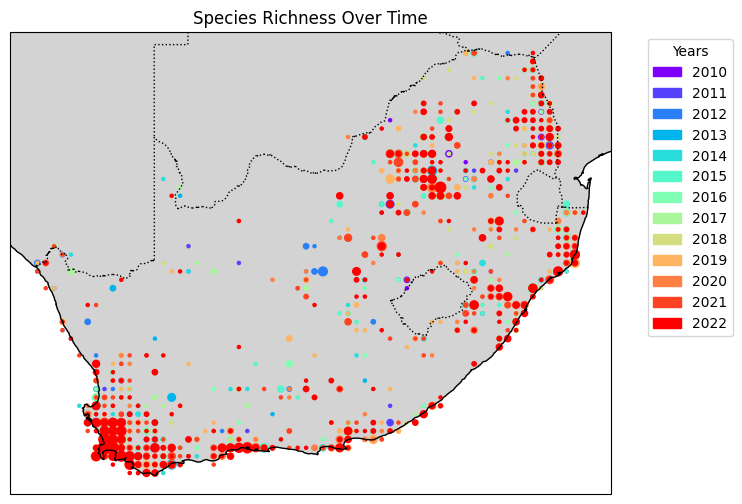

In [35]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land features using cartopy
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define a colormap with a range of colors using the 'rainbow' colormap
cmap = plt.cm.get_cmap('rainbow', len(species_richness.columns) - 2)  # Adjust the number of colors as needed

# List to store patches for the legend
legend_patches = []

# Plot the points with color and size variations based on year and species richness
for i, year in enumerate(species_richness.columns[2:]):  # Start from the 3rd column (first year)
    if isinstance(year, int):  # Check if the column represents a year
        color = cmap(i)  # Get a color from the colormap
        gdf.plot(ax=ax, markersize=species_richness[year]*5, color=color, transform=ccrs.PlateCarree())  # Specify transform

        # Create a patch for this year to include in the legend
        # Now using mpatches since we imported it
        legend_patches.append(mpatches.Patch(color=color, label=str(year)))

# Customize the map
plt.title('Species Richness Over Time')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add the legend outside of the plot
plt.legend(handles=legend_patches, title="Years", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Summarise species richness by year, ignoring observation coordinates

In [36]:
# Set the index to 'qds_lat' and 'qds_lon'
species_richness_indexed = species_richness.set_index(['qds_lat', 'qds_lon'])

# Sum species richness across rows (i.e., per year)
species_richness_sum = species_richness_indexed.sum(axis=0)

# Filter out non-numeric columns if necessary (i.e., columns that do not represent years)
numeric_columns = species_richness_sum.index[species_richness_sum.index.map(lambda x: isinstance(x, (int, float)))]
species_richness_sum_filtered = species_richness_sum[numeric_columns]

# Display the resulting table
print(species_richness_sum_filtered)

year
2010     86.0
2011    127.0
2012    171.0
2013    194.0
2014    273.0
2015    329.0
2016    342.0
2017    291.0
2018    345.0
2019    458.0
2020    427.0
2021    564.0
2022    711.0
dtype: float64


> Use `matplotlib.pyplot` to make a static line chart or plot, to visualize changes over time or trends in your data. In the context of ecological modeling, such as species richness, line plots are useful for showing how biodiversity metrics evolve over time. In the example provided, we first transpose the data to organize species richness by year, then sum the number of species across all locations for each year. This gives an overall view of species richness trends over time. We then filter out non-numeric index values to ensure that only valid year data is plotted. Finally, using `plt.plot()`, a line chart is generated, showing the change in species richness across the years, providing a clear visual representation of temporal biodiversity trends.

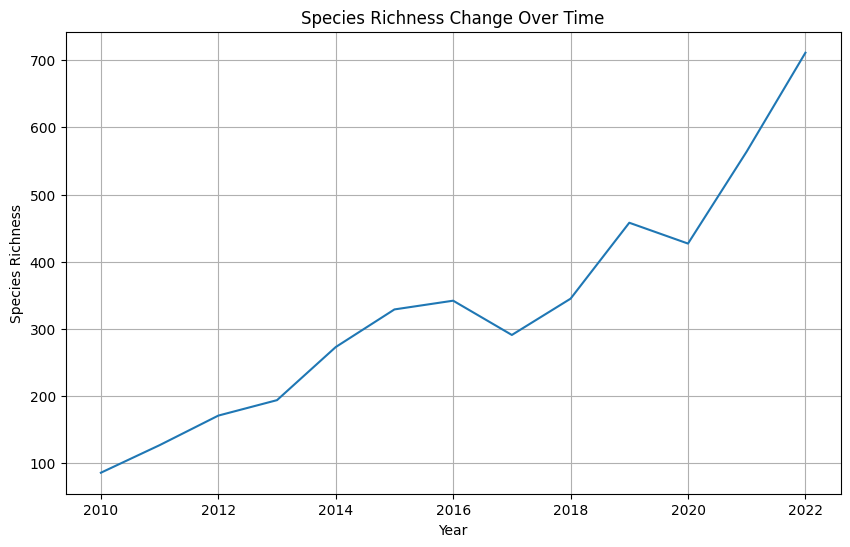

In [37]:
# Plot results as a line chart, showing how species_richness has changed over time

# Create a line chart
plt.figure(figsize=(10, 6))
# Plot using the filtered data
plt.plot(species_richness_sum_filtered.index, species_richness_sum_filtered.values)
plt.xlabel('Year')
plt.ylabel('Species Richness')
plt.title('Species Richness Change Over Time')
plt.grid(True)
plt.show()

> When plotting species richness directly from GBIF data, it is essential to be mindful of potential sampling bias caused by unequal sampling effort across time. For example, an apparent increase in species richness over time might not necessarily reflect real biodiversity changes, but rather a rise in data collection due to factors like the growing popularity of citizen science. More people participating in biodiversity surveys can lead to more records being submitted, which could inflate species richness counts without corresponding ecological changes.

> To visualise this, you can plot both species richness and total occurrences over time. First, the total number of unique species is calculated by grouping data by latitude, longitude, and year, then summing the species counts. Simultaneously, the total number of observations (occurrences) per year is calculated by summing the counts across all locations. By plotting these two trends together on a dual-axis chart, you can visually assess whether increases in species richness coincide with a rise in sampling effort. This approach provides a more balanced interpretation of biodiversity trends by highlighting potential biases introduced by unequal data collection.

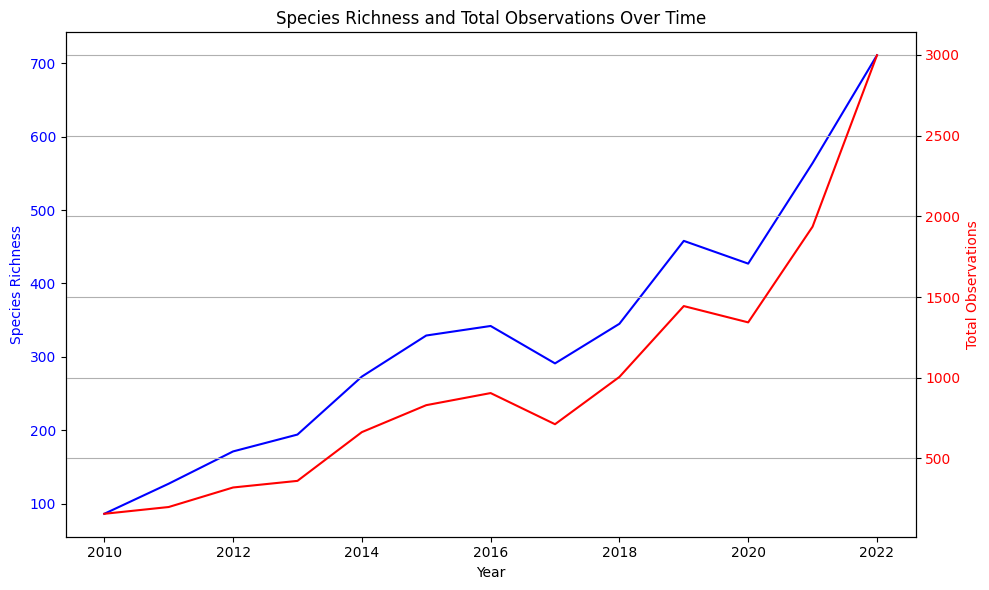

In [38]:
# Plot results as a line chart, showing how species_richness and the count of observations has changed over time

# Calculate total observations per year (Corrected)
obs_count = qds_sum.groupby(['qds_lat', 'qds_lon', 'year'])['count'].sum().unstack()
total_observations_per_year = obs_count.sum(axis=0)  # Sum across all locations for each year

# Create a line chart with two lines: Species Richness and Total Observations
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Species Richness
ax1.plot(species_richness_sum_filtered.index, species_richness_sum_filtered.values, 'b-', label='Species Richness')
ax1.set_xlabel('Year')
ax1.set_ylabel('Species Richness', color='b')
ax1.tick_params('y', labelcolor='b')

# Create a second y-axis for Total Observations
ax2 = ax1.twinx()
ax2.plot(total_observations_per_year.index, total_observations_per_year.values, 'r-', label='Total Observations')
ax2.set_ylabel('Total Observations', color='r')
ax2.tick_params('y', labelcolor='r')

# Add title, grid, and legend
plt.title('Species Richness and Total Observations Over Time')
plt.grid(True)
fig.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

### Environmental data cube

> Data Cubes are a powerful tool for managing and analyzing large-scale environmental data, such as rainfall, surface water availability, and other critical ecological variables. By structuring environmental data in a multi-dimensional array—typically with dimensions of space, time, and variables—Data Cubes allow for efficient storage, access, and analysis of these datasets. In the context of ecological modeling, Data Cubes enable researchers to examine the dynamic relationships between species distributions and environmental factors over time and across large regions. For example, analyzing rainfall patterns alongside species richness can reveal how water availability influences biodiversity, while integrating surface water data can help assess habitat quality or species movement patterns. The use of Data Cubes allows for scalable, repeatable analysis, making it a valuable asset for ecosystem monitoring and biodiversity conservation efforts.

First check the structure of your datasets

In [39]:
# Check how many images are in the collection
print(f'Number of images in Rainfall collection: {rain.size().getInfo()}')
print(f'Number of images in Water Occurrence collection: {water_occ.size().getInfo()}')

Number of images in Rainfall collection: 936
Number of images in Water Occurrence collection: 144


> To match the resolution of species richness data in a Data Cube, it is often necessary to aggregate higher-resolution environmental data, such as monthly 5 km² rainfall data from the CHIRPS dataset, into an annual scale. This involves summing the monthly rainfall values for each 5 km² grid cell over the course of a year to calculate the total annual rainfall for each location. This process ensures that the temporal resolution of the rainfall data aligns with the species richness Data Cube, allowing for direct comparisons and integrated analyses. By converting monthly rainfall data to annual totals, we can more effectively explore how long-term patterns in water availability influence biodiversity, particularly when looking at species richness trends in ecological models.

###### >> Design function - **`calculate_annual_rainfall`** at QDS

In [40]:
# Function to calculate total annual rainfall for a given year
def calculate_annual_rainfall(year):
    """
    Calculates the total rainfall for a given year.

    Args:
        year: The year to calculate rainfall for.

    Returns:
        An ee.Image representing the total rainfall for the year at 0.25° x 0.25° resolution.
    """
    year_start = ee.Date.fromYMD(year, 1, 1)
    year_end = ee.Date.fromYMD(year, 12, 31)

    # Assuming `rain` is an ee.ImageCollection of rainfall data
    annual_rainfall = rain.filterDate(year_start, year_end).sum()  # Sum rainfall over the year

    # Reproject the result to quarter-degree resolution (0.25° x 0.25°)
    scale_in_meters = 0.25 * 111320  # Approximate conversion from degrees to meters at the equator
    annual_rainfall_resampled = annual_rainfall.reproject(crs='EPSG:4326', scale=scale_in_meters)

    return annual_rainfall_resampled


###### >> Run function - **`calculate_annual_rainfall`**

In [41]:
# Map the function to calculate annual rainfall for each year
annual_rainfall_images = years.map(calculate_annual_rainfall)

# Convert the list of images to an ImageCollection
annual_rainfall_collection = ee.ImageCollection(annual_rainfall_images) # convert ee.List to ee.ImageCollection

# Check how many images are in the collection
print(f'Number of images in Rainfall collection: {annual_rainfall_collection.size().getInfo()}')


Number of images in Rainfall collection: 13


In [42]:
# Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

# Define visualization parameters for the raster
rainYrVis = {
    # 'bands': ['rain'],  # Band index starts from 0 in Earth Engine
    'palette': ['9e0142', 'd53e4f', 'f46d43', 'fdae61', 'fee08b', 'ffffbf', \
                    'e6f598', 'abe0a4', '66c2a5', '3288bd', '5e4fa2'],  # Define your color palette
    'min': 40,  # Minimum value for visualization
    'max': 1200,  # Maximum value for visualization
    'opacity': 0.4
}

Map.addLayer(annual_rainfall_collection.mean().clip(region), rainYrVis, 'Annual Mean Rainfall (mm)')

# # Center the map to the extent of the 'region'
# Map.centerObject(region, 5)
# Map


> To align the surface water data with the temporal and spatial resolution of the species richness and rainfall Data Cubes, the monthly 40 m² surface water data from the JRC Global Surface Water dataset is aggregated into annual surface water permanency. This is done by summing or averaging the monthly water recurrence values over a year for each 40 m² grid cell. The resulting annual metric indicates how consistently water is present throughout the year, capturing its permanency. This aggregation ensures that the data is on the same temporal and spatial scale as the other variables, allowing for integrated ecological modeling. By summarizing surface water into annual measures, we can better understand the relationship between permanent water availability and species richness or ecosystem changes over time.

###### >> Design function - **`count_water_image`**

In [45]:
def count_water_image(image_collection):
  """Creates a new image from the imageCollection that counts all the values of 2.

  Args:
    image_collection: An ee.ImageCollection.

  Returns:
    An ee.Image representing the count of values equal to 2 in each pixel across
    the image collection.
  """
  def count_twos(image):
    # Create a binary image where 1 represents pixels with value 2, 0 otherwise.
    binary_image = image.eq(2)
    return binary_image

  # Map the count_twos function over the image collection to get a new collection
  # of binary images.
  binary_image_collection = image_collection.map(count_twos)

  # Sum the binary images in the collection to get the total count of twos per pixel.
  count_image = binary_image_collection.sum()

  return count_image


###### >> Run function - **`count_water_image`**

In [52]:
#  Example usage:
# Assuming you have an ImageCollection called 'water'
count_of_twos_image = count_water_image(water)

# # You can then add this image to your map:
# Map.addLayer(count_of_twos_image, {
#     'min': 1,
#     'max': 133,  # Adjust max based on your expected count values
#     'palette': cm.palettes.Reds,
# }, 'Count Water')

###### >> Design function - **`calculate_distance_to_water_per_year`** at QDS

In [53]:
# Bits 0-1: Water detection
# 0: No data
# 1: Not water
# 2: Water"

def calculate_distance_to_water_per_year(water_collection):
  """Calculates distance to water for each year in an image collection.

  Args:
    water_collection: An ee.ImageCollection containing water presence data.

  Returns:
    An ee.ImageCollection with a distance surface per year.
  """

  def calculate_distance_for_year(year):
    # Filter the collection for the given year.
    water_year = water_collection.filter(ee.Filter.calendarRange(year, year, 'year'))

    # Count the occurrences of water (value 2) for the year.
    water_presence_year = count_water_image(water_year)

    # Calculate the distance to water from the water presence image.
    distance_to_water = water_presence_year.distance(ee.Kernel.euclidean(100))

    # Add the year as a property to the image.
    distance_to_water = distance_to_water.set('year', year)
    return distance_to_water


  # Get a list of unique years in the collection.
  years = water_collection.aggregate_array('year').distinct().getInfo()

  # Map the distance calculation function to each year.
  distance_collection = ee.ImageCollection.fromImages(
      [calculate_distance_for_year(year) for year in years]
  )

  return distance_collection


###### >> Run function - **`calculate_distance_to_water_per_year`**

In [55]:
# Calculate distance to water for each year.
distance_collection = calculate_distance_to_water_per_year(water)

# Check how many images are in the collection
print(f'Number of images in Distance to Water collection: {distance_collection.size().getInfo()}')

# Example: Add the first image in the collection to the map.
if distance_collection.size().getInfo() > 0:
  Map.addLayer(distance_collection.first().clip(region), {
      'min': 0,
      'max': 25,
      'palette': ['white', 'green', 'blue']
  }, 'Distance to Water (First Year)')

Number of images in Distance to Water collection: 12


In [ ]:
# Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

# Define visualization parameters for the raster
distVis = {
    'palette': ['white','green','blue'],  # Define your color palette
    'min': 0,  # Minimum value for visualization
    'max': 25,  # Maximum value for visualization
    'opacity': 0.4
}

Map.addLayer(distance_collection.mean().clip(region), distVis, 'Annual Distance to Water')

# # Center the map to the extent of the 'region'
# Map.centerObject(region, 5)
# Map

----


## Analysis

### Relationship between environment and species richess

> xxx-How can I look at the relationship between the species richness of *Anseriformes = ducks, geese, and swans* and the different environmental variables. Give a simple example of the relationship between the mean or stdDev as well as one that looks at trends over time-xxx-xxx

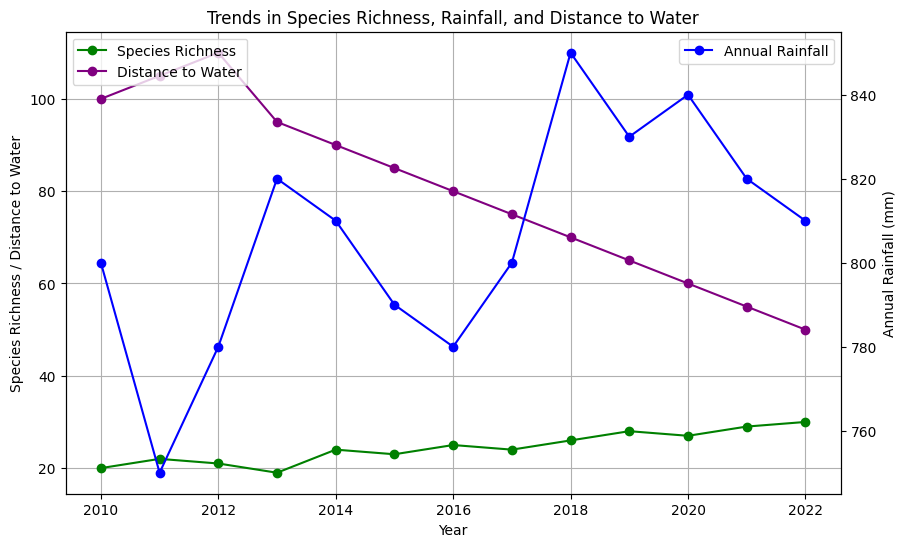

In [81]:
# Example data - replace this with your actual data
data = {
    'year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'species_richness': [20, 22, 21, 19, 24, 23, 25, 24, 26, 28, 27, 29, 30],
    'rainfall': [800, 750, 780, 820, 810, 790, 780, 800, 850, 830, 840, 820, 810],
    'distance_to_water': [100, 105, 110, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot species richness and distance to water on the primary y-axis
ax1.plot(df['year'], df['species_richness'], label='Species Richness', color='green', marker='o')
ax1.plot(df['year'], df['distance_to_water'], label='Distance to Water', color='purple', marker='o')

# Set the x-axis and y-axis labels
ax1.set_xlabel('Year')
ax1.set_ylabel('Species Richness / Distance to Water')
ax1.grid(True)

# Create a secondary y-axis for rainfall
ax2 = ax1.twinx()
ax2.plot(df['year'], df['rainfall'], label='Annual Rainfall', color='blue', marker='o')

# Set the secondary y-axis label
ax2.set_ylabel('Annual Rainfall (mm)')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add a title
plt.title('Trends in Species Richness, Rainfall, and Distance to Water')

# Show the plot
plt.show()

## Visualise results

> xxx-How can I best visualise my results-xxx

----


## Conclusion

> Using Google Colab, Google Earth Engine (EE), and GBIF provides a powerful combination of tools for conducting ecological modeling. Colab offers an accessible platform to write and execute Python code, enabling seamless integration with cloud-based resources like EE and biodiversity data from GBIF. EE’s vast environmental datasets, including climate, land cover, and hydrological information, can be processed alongside GBIF species occurrence data to explore ecological patterns and drivers of biodiversity change. This integration supports advanced analyses, such as species richness modeling, while taking advantage of Colab's scalability and ease of use. By leveraging these tools, researchers can conduct complex, data-intensive ecological studies without the need for local computing resources.

To take this further, you can explore:

Google Earth Engine Documentation for detailed guides on environmental data processing.
GBIF API to programmatically access species occurrence data.
geemap for interactive geospatial mapping with EE in Python.

----


## References

----
----

## Bonus Material

### Quarter Degree Squares (QDS) grid

###### Design function - **`create_qdgc_code`**

In [ ]:
def create_qdgc_code(lon, lat, sub_lon, sub_lat):
    """
    Generates a QDGC code in the format 'E034N27BB' where:
    - E/W indicates East/West longitude
    - N/S indicates North/South latitude
    - Sub_lon and sub_lat are in 0, 1 for the specific quarter within the grid cell
    """
    lon_dir = 'E' if lon >= 0 else 'W'
    lat_dir = 'N' if lat >= 0 else 'S'

    # Absolute values and format
    lon_abs = abs(lon)
    lat_abs = abs(lat)

    # Convert sub_lon and sub_lat to letter codes
    # Sub_lon: 0 -> A, 1 -> B
    # Sub_lat: 0 -> A, 1 -> B
    sub_lon_letter = chr(65 + sub_lon)  # A, B, ...
    sub_lat_letter = chr(65 + sub_lat)  # A, B, ...

    # Construct QDGC code
    qdgc_code = f"{lon_dir}{lon_abs:03d}{lat_dir}{lat_abs:02d}{sub_lon_letter}{sub_lat_letter}"
    return qdgc_code

###### Design function - **`create_quarter_degree_grid_with_qdgc`**

In [ ]:
def create_quarter_degree_grid_with_qdgc():
    # Initialize an empty list to store the grid cells
    grid_cells = []

    # Loop through latitude and longitude ranges
    for lon in range(-180, 180):
        for lat in range(-90, 90):
            # Create polygons for each quarter-degree grid cell
            for i in range(2): # Split each degree into two (0.5 degrees)
                for j in range(2):
                    # Define the coordinates for each polygon
                    minx, maxx = lon + i * 0.5, lon + (i + 1) * 0.5
                    miny, maxy = lat + j * 0.5, lat + (j + 1) * 0.5
                    # Calculate center point of the grid cell
                    center_lon = (minx + maxx) / 2
                    center_lat = (miny + maxy) / 2
                    # Create the polygon
                    poly = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

                    # Generate QDGC code using the custom function
                    qdgc_code = create_qdgc_code(lon, lat, i, j)

                    # Add a new row to the grid cells list
                    grid_cells.append({
                        'geometry': poly,
                        'qdgccode': qdgc_code,
                        'longitude': center_lon,
                        'latitude': center_lat
                    })

    # Create a GeoDataFrame from the grid cells list
    grid_gdf = gpd.GeoDataFrame(grid_cells, crs="EPSG:4326")
    return grid_gdf

##### Calculate species richness at QDS and plot as QDS grid

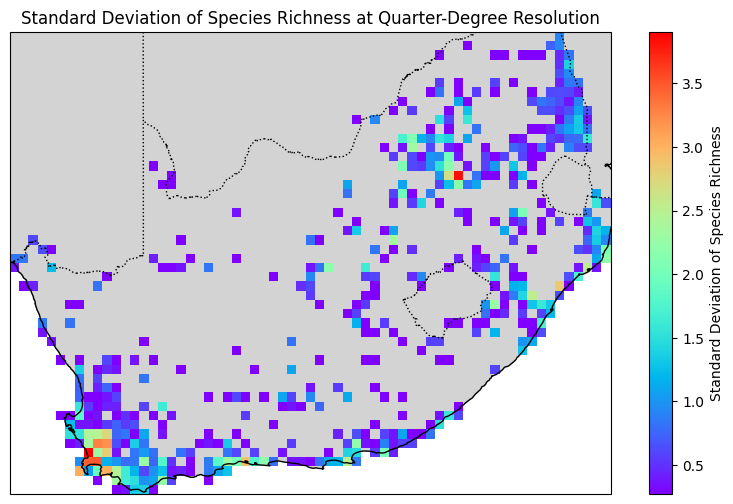

In [ ]:
# Calculate StdDev of species richness across all years
species_richness['StdDev'] = species_richness.iloc[:, 2:].std(axis=1)

# Define quarter-degree grid
grid_res = 0.25
lat_bins = np.arange(species_richness['qds_lat'].min(), species_richness['qds_lat'].max() + grid_res, grid_res)
lon_bins = np.arange(species_richness['qds_lon'].min(), species_richness['qds_lon'].max() + grid_res, grid_res)

# Initialize grid and populate with StdDev values
grid_stddev = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
for _, row in species_richness.iterrows():
    # Calculate lat_idx and lon_idx separately using np.digitize
    lat_idx = np.digitize(row['qds_lat'], lat_bins) - 1
    lon_idx = np.digitize(row['qds_lon'], lon_bins) - 1

    if 0 <= lat_idx < grid_stddev.shape[0] and 0 <= lon_idx < grid_stddev.shape[1]:
        grid_stddev[lat_idx, lon_idx] += row['StdDev']

# Mask zeros (treat as NaN)
grid_stddev[grid_stddev == 0] = np.nan

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot StdDev raster with 'rainbow' colormap
lon_grid, lat_grid = np.meshgrid(lon_bins[:-1], lat_bins[:-1])
c = ax.pcolormesh(lon_grid, lat_grid, grid_stddev, cmap='rainbow', transform=ccrs.PlateCarree())

plt.colorbar(c, ax=ax, label='Standard Deviation of Species Richness')
plt.title('Standard Deviation of Species Richness at Quarter-Degree Resolution')
plt.show()

Convert `ee.ImageCollection` to an `ee.Imgage` with multiple bands

In [ ]:
# Create an image with a band for each year
annual_rainfall_image = ee.ImageCollection.fromImages(annual_rainfall_images).toBands() \
  .rename(years.map(lambda year: ee.String('rain_').cat(ee.Number(year).int().format())).getInfo()) \
  .reproject(crs='EPSG:4326', scale=0.25)


# Print the image
print(annual_rainfall_image.bandNames().getInfo())

Map.addLayer(annual_rainfall_image.select('rain_2010').clip(region), rainVis, 'Mean Annual Rainfall')

['rain_2010', 'rain_2011', 'rain_2012', 'rain_2013', 'rain_2014', 'rain_2015', 'rain_2016', 'rain_2017', 'rain_2018', 'rain_2019', 'rain_2020', 'rain_2021', 'rain_2022']
